# Neha_HW 2_Part II: Computer Assignment Solution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.linear_model import LassoCV

# Part 1 & 2 - loading the data and replacing the missing values

In [2]:
df = pd.read_csv('AmesHousing_neha.csv')

numerical_variables = ['Lot Area', 'Lot Frontage', 'Year Built',
'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2',
'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF',
'2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area',
'Garage Area', 'Wood Deck SF', 'Open Porch SF',
'Enclosed Porch', '3Ssn Porch', 'Screen Porch',
'Pool Area']


discrete_variables = ['MS SubClass', 'MS Zoning', 'Street',
'Alley', 'Lot Shape', 'Land Contour',
'Utilities', 'Lot Config', 'Land Slope',
'Neighborhood', 'Condition 1', 'Condition 2',
'Bldg Type', 'House Style', 'Overall Qual',
'Overall Cond', 'Roof Style', 'Roof Matl',
'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
'Exter Qual', 'Exter Cond', 'Foundation',
'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
'BsmtFin Type 1', 'Heating', 'Heating QC',
'Central Air', 'Electrical', 'Bsmt Full Bath',
'Bsmt Half Bath', 'Full Bath', 'Half Bath',
'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual',
'TotRms AbvGrd', 'Functional', 'Fireplaces',
'Fireplace Qu', 'Garage Type', 'Garage Cars',
'Garage Qual', 'Garage Cond', 'Paved Drive',
'Pool QC', 'Fence', 'Sale Type', 'Sale Condition']

In [3]:
# replace all the missing values for numerical features with zeros
for row in range(2930):
    for column in numerical_variables:
        if np.isnan(df.loc[row,column]):
            df.loc[row,column] = 0

# all categorial features once converted to string will use 'nan' to indicate missing value
for column in discrete_variables:
    df = df.astype({column:'str'})

# let's use our own special string('#$@') to represent missing value 
for row in range(2930):
    for column in discrete_variables:
        if (df.loc[row,column] == 'nan'):
            df.loc[row,column] = '#$@'

# Part 3 -Split data into train, validation and test sets.

In [4]:
train = []
validation = []
test = []
for row in range(2930):
    if(df.loc[row,'Order'] % 5 == 3):
        validation.append(df.loc[row,:].values)
    elif(df.loc[row,'Order'] % 5 == 4):
        test.append(df.loc[row,:].values)
    else:
        train.append(df.loc[row,:].values)
df_train = pd.DataFrame(train, columns = df.columns)
df_validation = pd.DataFrame(validation, columns = df.columns)
df_test = pd.DataFrame(test, columns = df.columns)

# Part 4 - Simple one variable least squares linear regression

In [5]:
X_train_single = df_train.loc[:,'Gr Liv Area':'Gr Liv Area'].to_numpy()
Y_train = df_train.loc[:,'SalePrice'].to_numpy()
X_validation_single = df_validation.loc[:,'Gr Liv Area':'Gr Liv Area'].to_numpy()
Y_validation = df_validation.loc[:,'SalePrice'].to_numpy()

In [6]:
# choose your own model
reg_single = LinearRegression()
# train
reg_single.fit(X_train_single, Y_train)
# make predictions using the validation set
Y_pred = reg_single.predict(X_validation_single)

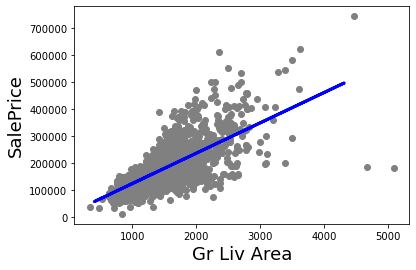

In [7]:
# Plot outputs
plt.scatter(X_train_single, Y_train,  color='grey')
plt.xlabel('Gr Liv Area', fontsize=18)
plt.ylabel('SalePrice', rotation=90, fontsize=18)
plt.plot(X_validation_single, Y_pred, color='blue', linewidth=3)
plt.show()

In [8]:
# The coefficients and intercept
print('Coefficients: ', reg_single.coef_, '\nIntercept: ', reg_single.intercept_)

Coefficients:  [112.41373299] 
Intercept:  12662.054191173054


**The equation of the line is "Y = 12662.054191173054 + 112.41373299 X"**

In [9]:
# The mean squared error
print('RMSE: %.2f'
      % sqrt(mean_squared_error(Y_validation, Y_pred)))

RMSE: 56299.05


**RMSE: 56299.05**

# Part 5 - Add more features and use one-hot encoding for categorical features

In [10]:
# define one hot encoding
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

# transform data
onehot = pd.DataFrame(encoder.fit_transform(df_train.loc[:,discrete_variables]))
X_train_numerical = df_train.loc[:,numerical_variables]
X_train_multiple = X_train_numerical.join(onehot)
reg_multiple = LinearRegression()

# train
reg_multiple.fit(X_train_multiple, Y_train)

# transform validation data
onehot_validation = pd.DataFrame(encoder.transform(df_validation.loc[:,discrete_variables]))
X_validation_numerical = df_validation.loc[:,numerical_variables]
X_validation_multiple = X_validation_numerical.join(onehot_validation)

# predict
Y_pred_multiple = reg_multiple.predict(X_validation_multiple)

# The mean squared error
print('RMSE: %.2f'
      % sqrt(mean_squared_error(Y_validation, Y_pred_multiple)))

RMSE: 26700.24


**RMSE: 26700.24**

# Part 6 - Apply standardization and use Lasso Regression

In [11]:
# normalize the features by subtracting the mean and dividing by the standard deviation
scaler = preprocessing.StandardScaler().fit(X_train_multiple)
X_train_scaled = scaler.transform(X_train_multiple)
X_validation_scaled = scaler.transform(X_validation_multiple)

Text(0, 0.5, 'Mean square error')

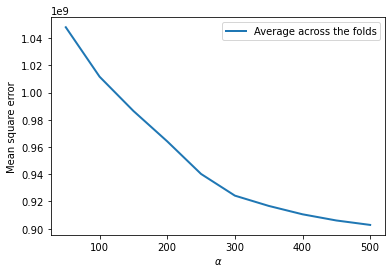

In [12]:
alphas = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500];

reg_lasso = LassoCV(alphas=alphas).fit(X_train_scaled, Y_train)

# Display results
plt.figure()
plt.plot(reg_lasso.alphas_, reg_lasso.mse_path_.mean(axis=-1), label='Average across the folds', linewidth=2)
plt.legend()
plt.xlabel(r'$\alpha$')
plt.ylabel('Mean square error')

In [13]:
error_v = [] # keep track of error in validation set
error_t = [] # keep track of error in training set
min_error = 100000 # initialize with big number than expected
best_alpha = 50 # initialize with the first value we are going to try
for alpha in alphas:
    reg_lasso = linear_model.Lasso(alpha=alpha)
    # train
    reg_lasso.fit(X_train_scaled, Y_train)
    # predict
    Y_pred_lasso_v = reg_lasso.predict(X_validation_scaled)
    Y_pred_lasso_t = reg_lasso.predict(X_train_scaled)
    # compute RMSE
    error_i_v = sqrt(mean_squared_error(Y_validation, Y_pred_lasso_v))
    error_i_t = sqrt(mean_squared_error(Y_train, Y_pred_lasso_t))
    error_v.append(error_i_v)
    error_t.append(error_i_t)
    # keep the record of lowest error
    if(error_i_v < min_error):
        min_error = error_i_v
        best_alpha = alpha
print('alpha =',best_alpha,' with minimum RMSE =',min_error)

alpha = 450  with minimum RMSE = 24191.665064500732


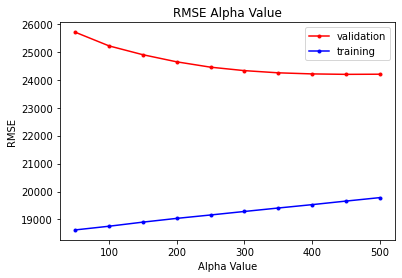

In [14]:
plt.figure()
plt.plot(alphas, error_v, color='red', label='validation', marker = '.')
plt.plot(alphas, error_t, color='blue', label='training', marker = '.')
plt.title('RMSE Alpha Value')
plt.xlabel('Alpha Value')
plt.ylabel('RMSE')
plt.legend(loc='best')
plt.show()

**Briey explain the concept of over-ftting and how this graph can be used to detect it.**

Overfitting means that the model performs well on training data but performs poorly to predict new data. In the graph above, we can clearly see the gap between training and validation RMSE plots which can be used to detects over-fitting.

# Part 7 - Use test data for each model and compare RMSE

In [15]:
X_test_single = df_test.loc[:,'Gr Liv Area':'Gr Liv Area'].to_numpy()
Y_test = df_test.loc[:,'SalePrice'].to_numpy()
Y_pred_test = reg_single.predict(X_test_single)
# The mean squared error
print('single variable model RMSE: %.2f'
      % sqrt(mean_squared_error(Y_test, Y_pred_test)))

onehot_test = pd.DataFrame(encoder.transform(df_test.loc[:,discrete_variables]))
X_test_numerical = df_test.loc[:,numerical_variables]
X_test_multiple = X_test_numerical.join(onehot_test)
Y_pred_multiple_test = reg_multiple.predict(X_test_multiple)
# The mean squared error
print('the least squares model RMSE: %.2f'
      % sqrt(mean_squared_error(Y_test, Y_pred_multiple_test)))

X_test_scaled = scaler.transform(X_test_multiple)
Y_pred_lasso_test = reg_lasso.predict(X_test_scaled)
print('the regularized model RMSE: %.2f'
      % sqrt(mean_squared_error(Y_test, Y_pred_lasso_test)))

single variable model RMSE: 55457.72
the least squares model RMSE: 36034.59
the regularized model RMSE: 33983.69


Model Name | RMSE
:-------------- | :---------------
single variable model | 55457.72
the least squares model | 36034.59
the regularized model | 33983.69